# Temprature effect on Ice core

On polar regions such Greenland, everytime that it snows, the snow accumulates on top of previous snow. After several years the snow gets compacted and preserves the environmental conditions of the past. One of the most important features that affects snow accumulation is temperature. In this study, I aim to see the effect of temperature on snow layers. 

To do so, I need data from snow columns (ice core data) and temperature data from satellite. Schaller et al. have been to northern parts of Greenland and they have collected several samples of ice cores (4 meter of snow) and they took X-ray image of it. The X-ray image can tell us about the density of snow layers, and we know that these 4 meters of snow is almost equal to 4 years. Thus, I am trying to see the effect of temperature on the density of icecore during these years to check the correlation and interpretation of signal.

link to ice core data: https://doi.pangaea.de/10.1594/PANGAEA.867873 

link to paper for more description of the ice core project:https://tc.copernicus.org/articles/10/1991/2016/

Next I need the temperature distriution of the 4 years that I found with help of CVL with following title

Multilayer Greenland Ice Surface Temperature, Surface Albedo, and Water Vapor from MODIS
Earth Science Data and Information System (ESDIS) Project, ESDIS
Datacenter: NASA National Snow and Ice Data Center Distributed Active Archive Center
Collection: ADC, GCW
Metadata identifier: MODGRNLD

Also there are some obsticles for downloading the data that is dicussed here:

https://github.com/CryosphereVirtualLab/public-notebooks/issues/13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
import seaborn as sns
import tempfile
import requests
import numpy as np
import netCDF4 as nc
import os
import earthaccess
import glob
# Setup
%matplotlib inline
import matplotlib
params = {'font.size'     : 14,
          'figure.figsize':(15.0, 8.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,}
matplotlib.rcParams.update(params)
sns.set()


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Step 1, Ice core data

Getting the Ice core data from Pangaea then averaging and sorting to pandas dataframe. In this part, having the pangaea url is necessary. This is the link to the ice core data. It has columns that are describing the density, Lon and Lat, and time of pulling out the ice cores.
This function gets the data from the data base and makes a temporary directory, then the data (tab delimited) will be tranformed to a Pandas dataframe.

In [2]:
def get_icecore_data():
    # url to data file
    data_url = 'https://doi.pangaea.de/10.1594/PANGAEA.867873?format=textfile'

    # create temporary directory
    with tempfile.TemporaryDirectory() as tmpdirname:

        fpath = os.path.join(tmpdirname, 'N2E_density.tab')

        # create a request link to the file
        r = requests.get(data_url, allow_redirects=True)

        # open a file and write the linked file into it
        open(fpath, 'wb').write(r.content)

        # load the dataset on to a variable
        # it will be available after the temporary directory has been deleted agian
        with open(fpath) as inp:
            line_list = list((line for line in inp))
            data = list(line.split('\t') for line in line_list[38:])
            for i in range (len (data)):
                data[i][-1] = float(data[i][-1][:-2])
                        
            columns = list(line_list[37].split('\t'))
            columns[-1] = columns[-1][:-1]
            df = pd.DataFrame(data, columns=columns)
    return df

There are several ice cores collected from different locations as given in the ice core data, but we need an average of density.
An average density is less affected by the local noise such as wind. The following function is averaging the density of the cores that are comming from different Lats.

In [3]:
# thsi function returns the icecore density (average) from 18 collected samples from Greenland
#https://doi.org/10.5194/tc-10-1991-2016

def icecore_density(icecore_data):    
    lats = icecore_data['Latitude'].unique()
    checker = 0
    for lat in lats:
        print ('Averaging for Latitude ',lat, 'Done')
        if checker == 0:
            density = icecore_data[icecore_data['Latitude'] == lat ]['Density [g/cm**3]'].to_numpy()
            checker = 1
        else:
            _new = icecore_data[icecore_data['Latitude'] == lat ]['Density [g/cm**3]'].to_numpy()

            if len(density) >= len(_new):
                density = density[:len(_new)] + _new
            else:
                density = density + _new[:len(density)]
    return density/len(lats)

In [4]:
icecore_data = get_icecore_data()
ice_density = icecore_density(icecore_data)




Averaging for Latitude  77.44433 Done
Averaging for Latitude  77.36690 Done
Averaging for Latitude  77.25429 Done
Averaging for Latitude  77.12010 Done
Averaging for Latitude  76.98195 Done
Averaging for Latitude  76.84788 Done
Averaging for Latitude  76.71337 Done
Averaging for Latitude  76.52426 Done
Averaging for Latitude  76.40034 Done
Averaging for Latitude  76.32535 Done
Averaging for Latitude  76.24889 Done
Averaging for Latitude  76.17770 Done
Averaging for Latitude  76.10455 Done
Averaging for Latitude  76.01559 Done
Averaging for Latitude  75.93539 Done
Averaging for Latitude  75.85845 Done
Averaging for Latitude  75.70614 Done
Averaging for Latitude  75.62934 Done


On the bove, averaged ice cores density is done by their Lat

# Step2, Temperature data from NSIDC 

Downloading, processing and sorting temperature data from NSIDC. At first we need to log in then find granuls of data, filter them and download it.

This is an interactive cridential input section, so please use your own user and pass for plug in to NSIDC

In [5]:
# put your cridentials (https://urs.earthdata.nasa.gov/)
auth = earthaccess.login(strategy="interactive")

Enter your Earthdata Login username: faramarz.bagherzadeh
Enter your Earthdata password: ········
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 03/29/2023


When you are looged in then, the weather data (temperature data) from the NASA satellite products can be downloaded as follow:
In case you look for another data, make sure you have the correct concept_id

In [6]:
#Getting granules of data
earthaccess.login(strategy="environment")
granules = earthaccess.search_data(
    concept_id="C1597320047-NSIDC_ECS",
    bounding_box=(-51.06, 75.6, -35.9, 77.4),
    cloud_hosted=True,
    downloadable = True,
    temporal=("2011-05", "2015-05"),
    count=100000
)


We are already authenticated with NASA EDL
Granules found: 32617


There are many granuls of data to download, but we only need the daily data, so to filter it out the following code is implemented. Reffering to https://github.com/CryosphereVirtualLab/public-notebooks/issues/13

In [7]:
# filtering the granules, we need only daily data 
daily_granules = []
i = 1
for gr in granules[:]:
    if 'daily' in str(gr):
        i += 1
        daily_granules.append(gr)
print ('found {} number of daily files'.format(i))

found 1463 number of daily files


In [8]:
#downloading the selected granules in local path
earthaccess.download(daily_granules[:], local_path="./modis_data")

 Getting 1462 granules, approx download size: 24.29 GB


QUEUEING TASKS | :   0%|          | 0/1462 [00:00<?, ?it/s]

File MODGRNLD.2011121.daily.v01.1.nc already downloaded
File MODGRNLD.2011122.daily.v01.1.nc already downloaded
File MODGRNLD.2011123.daily.v01.1.nc already downloaded
File MODGRNLD.2011124.daily.v01.1.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/1462 [00:00<?, ?it/s]

Error while downloading the file MODGRNLD.2011137.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.05.17/MODGRNLD.2011137.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011138.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011152.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011153.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.06.01/MODGRNLD.2011152.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011168.daily.v01.1.ncError while downloading the file MODGRNLD.2011163.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.06.17/MODGRNLD.2011168.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011184.daily.v01.1.ncError while downloading the file MODGRNLD.2011186.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011185.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.07.03/MODGRNLD.2011184.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2011199.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.07.18/MODGRNLD.2011199.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011202.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011201.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2011217.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.08.05/MODGRNLD.2011217.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011215.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011216.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011218.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\Mac

Error while downloading the file MODGRNLD.2011232.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.08.20/MODGRNLD.2011232.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011236.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011250.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.09.07/MODGRNLD.2011250.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011253.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011251.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011254.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011252.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_fi

Error while downloading the file MODGRNLD.2011265.daily.v01.1.ncError while downloading the file MODGRNLD.2011269.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011268.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011267.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011266.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.09.26/MODGRNLD.2011269.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_fi

Error while downloading the file MODGRNLD.2011285.daily.v01.1.ncError while downloading the file MODGRNLD.2011284.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011281.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.10.11/MODGRNLD.2011284.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011282.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\Mac

Error while downloading the file MODGRNLD.2011300.daily.v01.1.ncError while downloading the file MODGRNLD.2011297.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011298.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011299.daily.v01.1.nc
Error while downloading the file MODGRNLD.2011296.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.10.23/MODGRNLD.2011296.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_fi

Error while downloading the file MODGRNLD.2011314.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.11.10/MODGRNLD.2011314.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011315.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011326.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.11.22/MODGRNLD.2011326.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011331.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011343.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.12.09/MODGRNLD.2011343.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011344.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2011355.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2011.12.21/MODGRNLD.2011355.daily.v01.1.nc

Error while downloading the file MODGRNLD.2011356.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012004.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.01.04/MODGRNLD.2012004.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012009.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012020.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.01.20/MODGRNLD.2012020.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012022.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012043.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.02.12/MODGRNLD.2012043.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012038.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012039.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012042.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012041.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_fi

Error while downloading the file MODGRNLD.2012057.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012058.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.02.26/MODGRNLD.2012057.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012072.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.03.12/MODGRNLD.2012072.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012073.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012074.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2012088.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.03.28/MODGRNLD.2012088.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012089.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012104.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.04.13/MODGRNLD.2012104.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012105.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012120.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.04.29/MODGRNLD.2012120.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012123.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012121.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2012136.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.05.15/MODGRNLD.2012136.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012137.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012160.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.06.08/MODGRNLD.2012160.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012161.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012176.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.06.24/MODGRNLD.2012176.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012180.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012199.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.07.17/MODGRNLD.2012199.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012200.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012218.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.08.05/MODGRNLD.2012218.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012219.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012233.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.08.20/MODGRNLD.2012233.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012234.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012250.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.09.06/MODGRNLD.2012250.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012252.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012251.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2012263.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012264.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.09.20/MODGRNLD.2012264.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012278.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.10.04/MODGRNLD.2012278.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012279.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012282.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.10.08/MODGRNLD.2012282.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012295.daily.v01.1.ncError while downloading the file MODGRNLD.2012294.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2012309.daily.v01.1.ncError while downloading the file MODGRNLD.2012310.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.11.05/MODGRNLD.2012310.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012323.daily.v01.1.nc
Error while downloading the file MODGRNLD.2012324.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.11.18/MODGRNLD.2012323.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012339.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.12.04/MODGRNLD.2012339.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012340.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2012355.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2012.12.20/MODGRNLD.2012355.daily.v01.1.nc

Error while downloading the file MODGRNLD.2012356.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013006.daily.v01.1.ncError while downloading the file MODGRNLD.2013005.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.01.05/MODGRNLD.2013005.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013026.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.01.26/MODGRNLD.2013026.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013025.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013040.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.02.09/MODGRNLD.2013040.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013041.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013042.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013057.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.02.26/MODGRNLD.2013057.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013058.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013072.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.03.13/MODGRNLD.2013072.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013074.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013092.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.04.02/MODGRNLD.2013092.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013093.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013107.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013106.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.04.17/MODGRNLD.2013107.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013108.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013120.daily.v01.1.ncError while downloading the file MODGRNLD.2013121.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013122.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.04.30/MODGRNLD.2013120.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013140.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013139.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.05.19/MODGRNLD.2013139.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013156.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.06.05/MODGRNLD.2013156.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013157.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013170.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.06.19/MODGRNLD.2013170.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013171.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013187.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.07.06/MODGRNLD.2013187.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013186.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013185.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013208.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.07.27/MODGRNLD.2013208.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013209.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013225.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.08.13/MODGRNLD.2013225.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013226.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013227.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013244.daily.v01.1.ncError while downloading the file MODGRNLD.2013245.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.09.02/MODGRNLD.2013245.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013261.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.09.18/MODGRNLD.2013261.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013262.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013275.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.10.02/MODGRNLD.2013275.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013276.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013277.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013290.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.10.17/MODGRNLD.2013290.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013291.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013292.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2013309.daily.v01.1.nc
Error while downloading the file MODGRNLD.2013308.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.11.04/MODGRNLD.2013308.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013324.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.11.20/MODGRNLD.2013324.daily.v01.1.nc

Error while downloading the file MODGRNLD.2013327.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013342.daily.v01.1.ncError while downloading the file MODGRNLD.2013343.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.12.09/MODGRNLD.2013343.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2013355.daily.v01.1.ncError while downloading the file MODGRNLD.2013356.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2013.12.21/MODGRNLD.2013355.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014005.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014006.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.01.05/MODGRNLD.2014005.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014019.daily.v01.1.ncError while downloading the file MODGRNLD.2014021.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014020.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.01.20/MODGRNLD.2014020.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2014036.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.02.05/MODGRNLD.2014036.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014037.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014052.daily.v01.1.ncError while downloading the file MODGRNLD.2014051.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.02.20/MODGRNLD.2014051.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014068.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014067.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.03.09/MODGRNLD.2014068.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014083.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.03.24/MODGRNLD.2014083.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014086.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014084.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014085.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\Mac

Error while downloading the file MODGRNLD.2014099.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.04.09/MODGRNLD.2014099.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014102.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014115.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.04.25/MODGRNLD.2014115.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014116.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014131.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.05.11/MODGRNLD.2014131.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014132.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014147.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.05.27/MODGRNLD.2014147.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014148.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014149.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2014163.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.06.12/MODGRNLD.2014163.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014174.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014192.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.07.11/MODGRNLD.2014192.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014193.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014217.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.08.05/MODGRNLD.2014217.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014218.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014237.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.08.25/MODGRNLD.2014237.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014238.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014252.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.09.09/MODGRNLD.2014252.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014253.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014261.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.09.18/MODGRNLD.2014261.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014268.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014286.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.10.13/MODGRNLD.2014286.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014287.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014300.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.10.27/MODGRNLD.2014300.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014301.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014304.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.10.31/MODGRNLD.2014304.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014317.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2014334.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.11.30/MODGRNLD.2014334.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014335.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014339.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014336.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014338.daily.v01.1.nc
Error while downloading the file MODGRNLD.2014337.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\l

Error while downloading the file MODGRNLD.2014352.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2014.12.18/MODGRNLD.2014352.daily.v01.1.nc

Error while downloading the file MODGRNLD.2014356.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2015005.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.01.05/MODGRNLD.2015005.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015009.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015007.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015008.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015006.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_fi

Error while downloading the file MODGRNLD.2015020.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.01.20/MODGRNLD.2015020.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015021.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2015035.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.02.04/MODGRNLD.2015035.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015036.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2015051.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.02.20/MODGRNLD.2015051.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015052.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2015072.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015071.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.03.13/MODGRNLD.2015072.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=sel

Error while downloading the file MODGRNLD.2015081.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015084.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015082.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.03.25/MODGRNLD.2015084.daily.v01.1.nc

Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2015097.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.04.07/MODGRNLD.2015097.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015100.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015098.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

Error while downloading the file MODGRNLD.2015115.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://n5eil01u.ecs.nsidc.org/DP2/MOST/MODGRNLD.001/2015.04.25/MODGRNLD.2015115.daily.v01.1.nc

Error while downloading the file MODGRNLD.2015114.daily.v01.1.nc
Error while downloading the file MODGRNLD.2015113.daily.v01.1.nc
Traceback (most recent call last):
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\earthaccess\store.py", line 498, in _download_file
    r.raise_for_status()
  File "D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\requests\models.py", line 960, in 

COLLECTING RESULTS | :   0%|          | 0/1462 [00:00<?, ?it/s]

['MODGRNLD.2011121.daily.v01.1.nc',
 'MODGRNLD.2011122.daily.v01.1.nc',
 'MODGRNLD.2011123.daily.v01.1.nc',
 'MODGRNLD.2011124.daily.v01.1.nc',
 'MODGRNLD.2011125.daily.v01.1.nc',
 'MODGRNLD.2011126.daily.v01.1.nc',
 'MODGRNLD.2011127.daily.v01.1.nc',
 'MODGRNLD.2011128.daily.v01.1.nc',
 'MODGRNLD.2011129.daily.v01.1.nc',
 'MODGRNLD.2011130.daily.v01.1.nc',
 'MODGRNLD.2011131.daily.v01.1.nc',
 'MODGRNLD.2011132.daily.v01.1.nc',
 'MODGRNLD.2011133.daily.v01.1.nc',
 'MODGRNLD.2011134.daily.v01.1.nc',
 'MODGRNLD.2011135.daily.v01.1.nc',
 'MODGRNLD.2011136.daily.v01.1.nc',
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 Exception(),
 'MO

# Processing the data granules


Now that we have the data granuls, we need to do pre processing them and turn it to a pandas data frame. To do so, we need to read each file with Glob library, then catching the calendar-date of data, and then putting daily avereged data to a pandas table under the related calendar-date tag.

In [9]:
def find_date(ds):
    # This functions reads the data_date
    date = None
    for var in ds.variables.values():
        data_date = var.data_date
        assert date == None or data_date == date , 'Date Missmatch in data package for day {}'.format(data_date)
        date = data_date
    return date

In [10]:
def get_data(ds):
    #This function returns a Pandas dataframe from the daily average values of each feature
    df = pd.DataFrame()
    df ['Date'] = [find_date(ds)]
    df['Ice_Surface_Temperature_Mean'] = [np.mean(ds['Ice_Surface_Temperature_Mean'][0, :, :])]
    df['Ice_Surface_Temperature_Melt_NoMelt'] = [np.mean(ds['Ice_Surface_Temperature_Melt_NoMelt'][0, :, :])]
    df['Albedo'] = [np.mean(ds['Albedo'][0, :, :])]
    df['Water_Vapor_Near_Infrared_Mean'] = [np.mean(ds['Water_Vapor_Near_Infrared_Mean'][0, :, :])]
    df['NSwaths_and_Hour_Tracker'] = [np.mean(ds['NSwaths_and_Hour_Tracker'][0, :, :])]
    return df


In [11]:
path = "./modis_data/*.nc"
files = glob.glob(path)
print ('There are {} [.nc] files'.format(len(files)))

There are 110 [.nc] files


This part creats the pandas dataframe from the data granuls with the help of two above functions.

In [12]:
#Creating a pandas data frame from granule data
output = get_data(nc.Dataset(files[0]))

for file in files[1:]:
    new_df = get_data(nc.Dataset(file))
    output = pd.concat([output, new_df], ignore_index=True,axis=0)

satellite_data = output
temp = satellite_data['Ice_Surface_Temperature_Mean'].to_numpy()

In [13]:
print (ice_density.shape)
print (temp.shape)

(12466,)
(110,)


# Step3, Interpolation 

We need interpolation to have same amount of records for satellite data and icecore data, also to see both signals in one graph with proper scale we need to normalize them

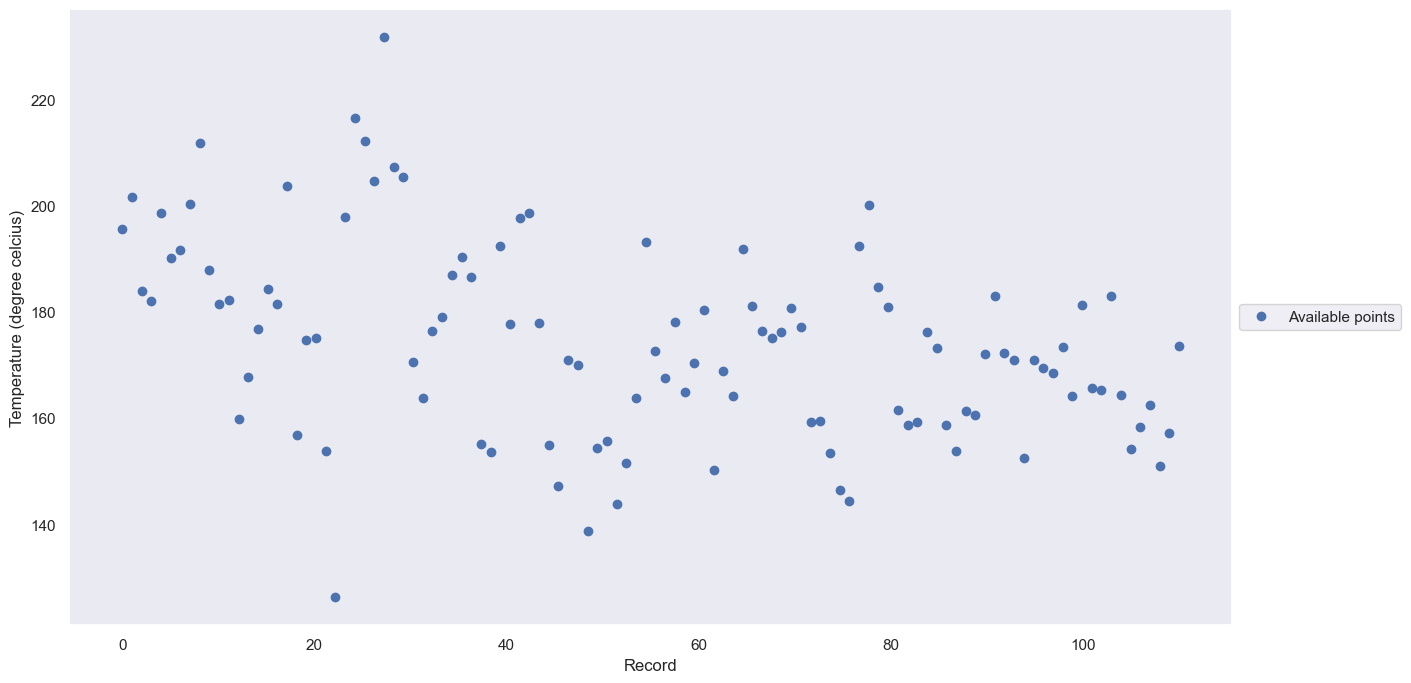

In [14]:
N = len(temp)
xmin, xmax = 0., len(temp)
xi = np.linspace(xmin, xmax, N)
yi = temp

plt.plot(xi,yi, 'o', label = "Available points")
plt.grid()
plt.xlabel("Record")
plt.ylabel("Temperature (degree celcius)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

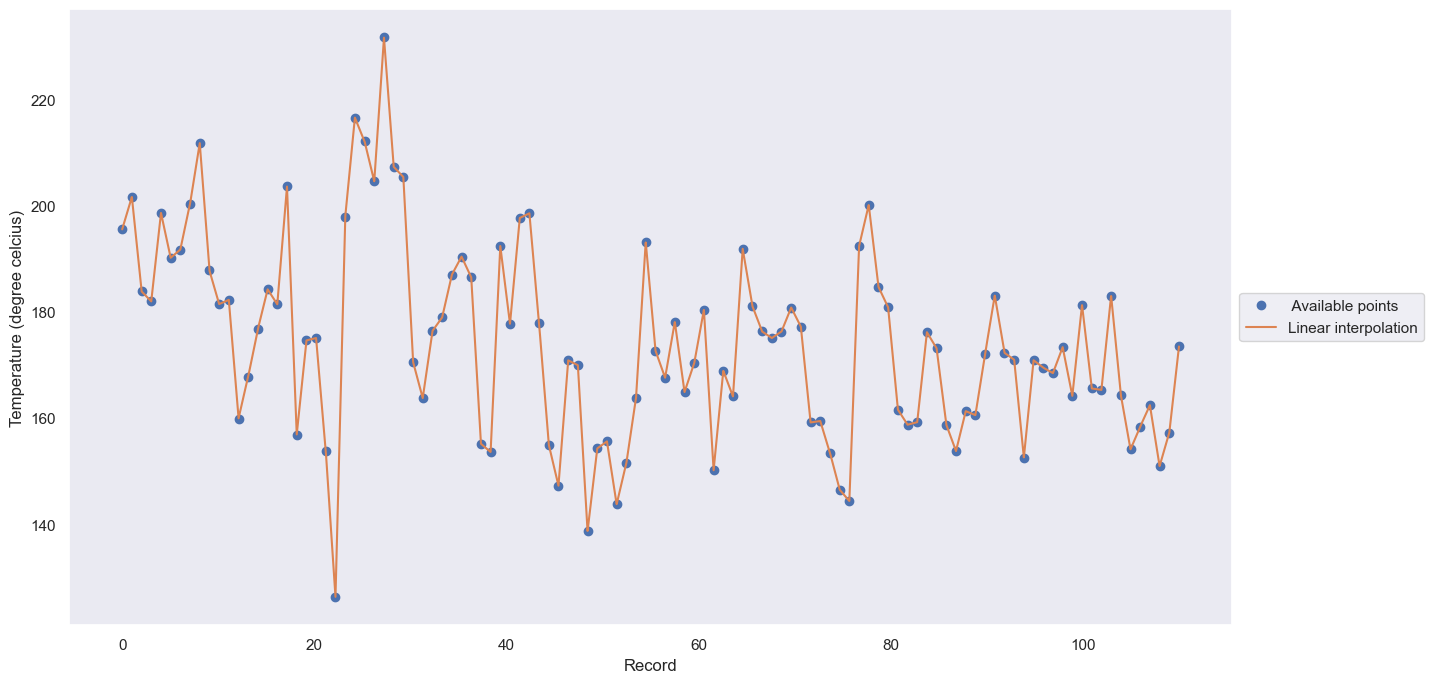

In [15]:

x = np.linspace(xmin, xmax, ice_density.shape[0])
interp = interpolate.interp1d(xi, yi, kind = "linear")
y_linear = interp(x)

new_temp = y_linear.copy()

plt.plot(xi,yi, 'o', label = " Available points")
plt.plot(x, y_linear, "-", label = "Linear interpolation")
plt.grid()
plt.xlabel("Record")
plt.ylabel("Temperature (degree celcius)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

now the icecore data and satellite data have the smae amount of rows

In [16]:

print(new_temp.shape)
print()

(12466,)



# Step4, Analysis 

Now that we have all the data lined up, we can start analysis both in quantitative and qualitative. Here first we are getting the statistical descriptions of each dataset, then checking the data distribution, and person correlatoin, and finally checking the signal allignments. 

In [17]:
combined_data = pd.DataFrame()
combined_data['ice_temperature'] = new_temp
combined_data['ice_density'] = ice_density

In [18]:
combined_data.describe()

,ice_temperature,ice_density
count,12466.000000,12466.000000
mean,174.163227,0.324717
std,16.909300,0.020921
min,126.355720,0.263278
25%,161.263453,0.313000
50%,172.265486,0.324000
75%,183.609111,0.339056
max,231.634545,0.389944


In [19]:
# for comparing two datasets we need to scale them down 
scaler = MinMaxScaler()
scaler.fit(combined_data)
normdata = pd.DataFrame(scaler.transform(combined_data.values), index=combined_data.index, columns=combined_data.columns)

D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [20]:
normdata.describe()

,ice_temperature,ice_density
count,12466.000000,12466.000000
mean,0.454104,0.485046
std,0.160614,0.165166
min,0.000000,0.000000
25%,0.331574,0.392544
50%,0.436078,0.479386
75%,0.543826,0.598246
max,1.000000,1.000000


temperature data is more diverse has higher variance than the ice core density data.

D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Software\Anaconda\envs\MachineLearning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


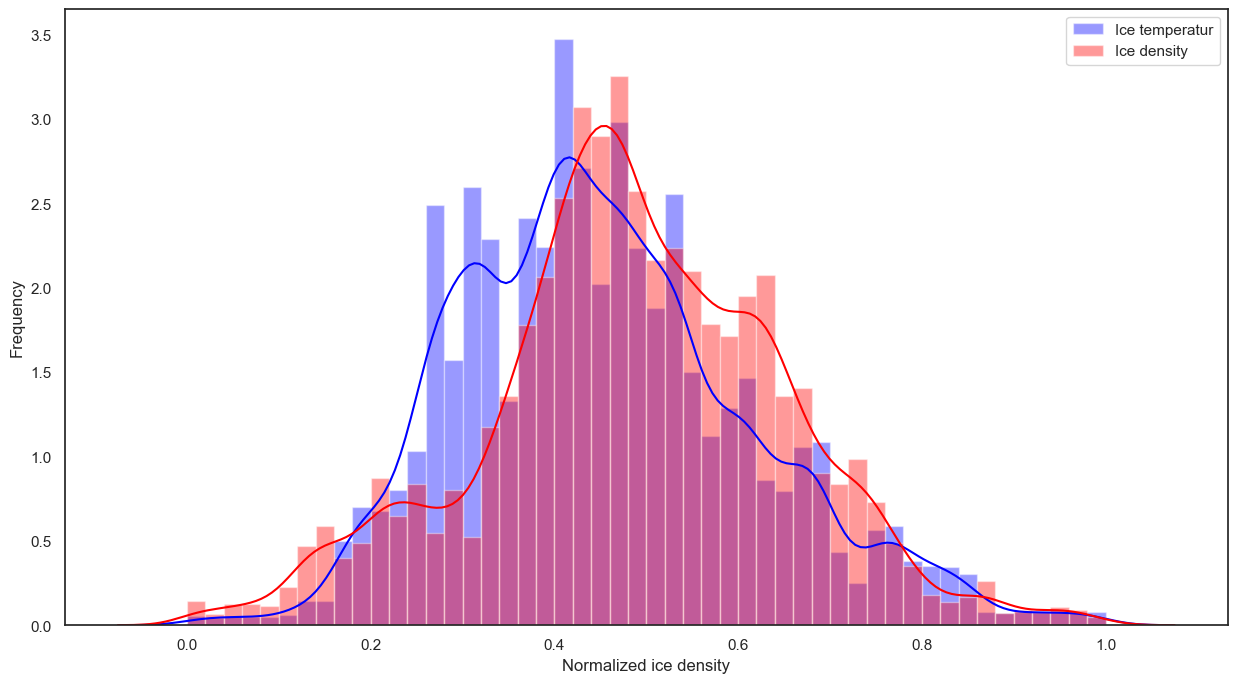

In [21]:
sns.set_style("white")
ax = sns.distplot(normdata.ice_temperature, color='blue', label='Ice temperatur')
ax = sns.distplot(normdata.ice_density, color='red', label = 'Ice density')
plt.ylabel('Frequency')
plt.xlabel('Normalized ice density')
plt.rcParams.update({'font.size': 14})
plt.legend()

We search for linear correlation between two distributions as follow:

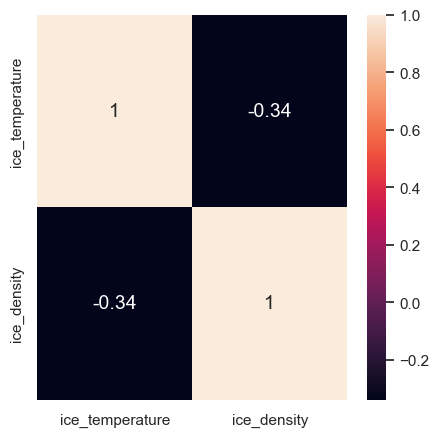

In [22]:
#Using Pearson Correlation
plt.figure(figsize=(5,5))
cor = normdata.corr()
sns.heatmap(cor, annot=True)
plt.show()

Here we search for signal alignment to check for how many seasons these to signals are aligned and how they behave after that period

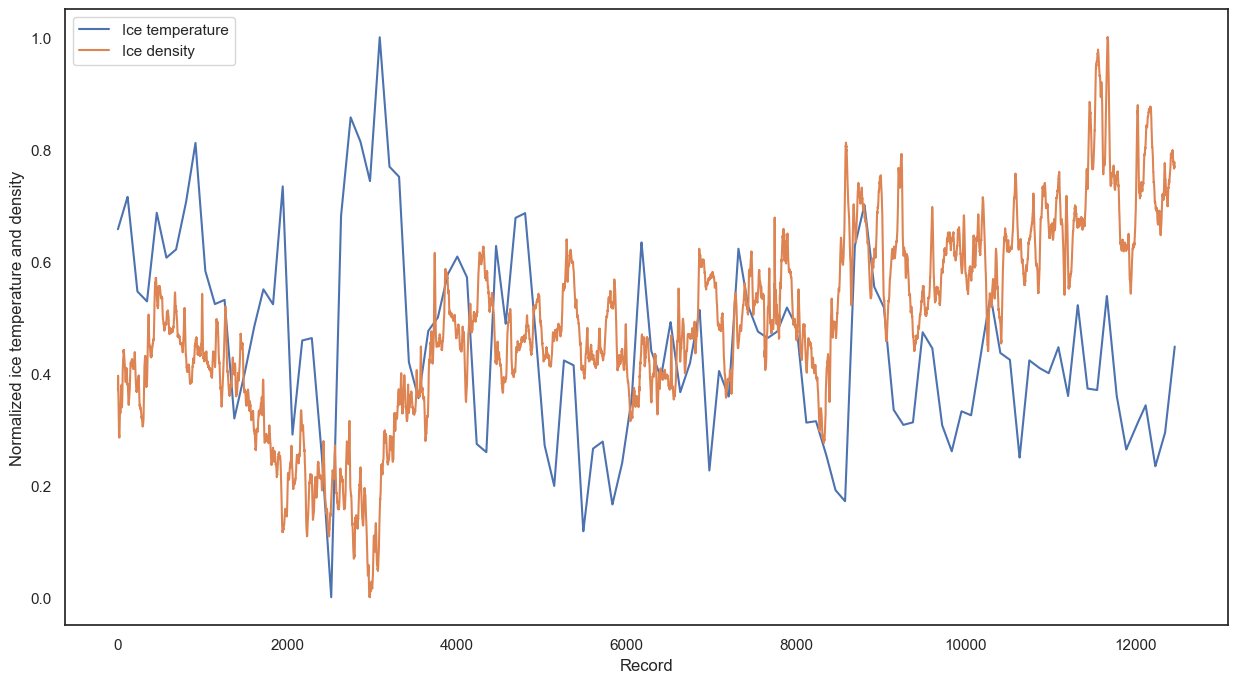

In [23]:
normdata['day'] = list(range(normdata.shape[0]))
sns.lineplot(data=normdata, x='day', y="ice_temperature", label = 'Ice temperature')
sns.lineplot(data=normdata, x='day', y="ice_density", label = 'Ice density')
plt.xlabel('Record')
plt.ylabel('Normalized ice temperature and density')
plt.legend()

# conclusion

After collecting ice core density data and sattelite temperature data (for 4 years), it is possible to normalize and compare these two data sets to see the effect of temperature on snow layers. The most technichal tools that are used in this notebook are the interpolation of two signals, normalization, histogram comparison, and Pearson correlation.
It is observed from the above Fig that the ice density signal is getting compacted immediately after the first seasonal change. It is also showing that the overal density copaction is increasing during the given four years in such way that the signal disappears after two years comparing to the temperature signal.